### Import starting libraries, initial parameters

In [21]:
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
import time


random.seed(42)
np.random.seed(42)

### Define initial variables 

In [22]:
# Problem size
#nbrblood = 100
#nbrcoll = 2000
#nbrprivh = 20
#nbrpubh = 30


# Define coords for each type of location
geodata = pd.read_csv('CommunityClubsTest-clean.csv')
bloodbankcoords = pd.read_csv('HSA bloodbank coordinates1.csv')
privhospcoords = pd.read_csv('Plot of Hospitals, Blood Banks & Community Centers- Private Hospital Plot.csv')
pubhospcoords = pd.read_csv('Plot of Hospitals, Blood Banks & Community Centers- Public Hospital Plot.csv')


x_coordCC = geodata['X'].values
y_coordCC = geodata['Y'].values
x_coordBB = bloodbankcoords['Longitude'].values
y_coordBB = bloodbankcoords['Latitude'].values
x_coord_privhosp = privhospcoords['Longitude'].values
y_coord_privhosp = privhospcoords['Latitude'].values
x_coord_pubhosp = pubhospcoords['Longitude'].values
y_coord_pubhosp = pubhospcoords['Latitude'].values

nbrblood = len(x_coordBB)
nbrcoll = len(x_coordCC)
nbrpubh = len(x_coord_pubhosp)
nbrprivh = len(x_coord_privhosp)

# TSP Definition
def tsp_nearest_neighbor(coords):
    if len(coords) <= 1:
        return 0
    dist_matrix = squareform(pdist(coords))
    visited = [0]
    cost = 0
    for _ in range(1, len(coords)):
        last = visited[-1]
        next_city = min(
            [i for i in range(len(coords)) if i not in visited],
            key=lambda x: dist_matrix[last][x]
        )
        cost += dist_matrix[last][next_city]
        visited.append(next_city)
    cost += dist_matrix[visited[-1]][0]  # return to start
    return cost

# Radius of earth (km)
R = 6371

def deg_to_rad(degrees):
    return degrees*(np.pi/180)

# Haversine distance function
def haversine(lat1, lon1, lat2, lon2):
    dlon = deg_to_rad(lon2 - lon1)
    dlat = deg_to_rad(lat2 - lat1)
    a = np.sin(dlat/2)**2 + np.cos(deg_to_rad(lat1)) * np.cos(deg_to_rad(lat2)) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c

# Computing distances between the various nodes
distancelct = np.empty((nbrblood, nbrcoll))
for i in range(nbrblood):
    for j in range(nbrcoll):
        distancelct[i, j] = haversine(y_coordBB[i], x_coordBB[i], y_coordCC[j], x_coordCC[j])

distanceBB_priv = np.empty((nbrblood, nbrprivh))
for i in range(nbrblood):
    for h in range(nbrprivh):
        distanceBB_priv[i, h] = haversine(y_coordBB[i], x_coordBB[i], y_coord_privhosp[h], x_coord_privhosp[h])

distanceBB_pub = np.empty((nbrblood, nbrpubh))
for i in range(nbrblood):
    for h in range(nbrpubh):
        distanceBB_pub[i, h] = haversine(y_coordBB[i], x_coordBB[i], y_coord_pubhosp[h], x_coord_pubhosp[h])

# Generate random blood collection amounts and capacities
q_c = np.random.randint(1, 10, nbrcoll)  # Amount of blood collected at each CC
g_b = np.random.randint(50, 100, nbrblood)  # Min blood required at each bank
q_b = np.random.randint(100, 200, nbrblood)  # Max capacity at each bank

# For hospital demand, generate random values for demonstration
hospital_demand = np.random.randint(1, 10, nbrprivh + nbrpubh)

# Prepare coordinates for plotting and TSP
comm_coords = list(zip(x_coordCC, y_coordCC))
bank_coords = list(zip(x_coordBB, y_coordBB))
privhosp_coords = list(zip(x_coord_privhosp, y_coord_privhosp))
pubhosp_coords = list(zip(x_coord_pubhosp, y_coord_pubhosp))

### Initialize ACO Parameters

In [31]:
# Starting parameters

# original = 100
num_ants = 100
num_iterations = 100000
alpha = 0.5         
beta = 2         
rho = 0.01    
Q = 10                      

# Find total number of objects for ACO
num_objects = nbrblood+nbrcoll+nbrprivh+nbrpubh
objects = [(random.randint(1, 20), random.randint(10, 100)) for _ in range(num_objects)]
capacity = q_b

# Initialize pheromons on each object to be 1
pheromones = np.ones((nbrblood, nbrcoll))

# calculate value/weight as one indicator for solution quality
heuristic = [val / wt for wt, val in objects]

### ACO iterations

1. Each ant builds a solution
2. Solution evaluated based on value and weight
3. Pheromones updated

In [37]:
# === Initialization ===
best_solution = None
best_cost = float('inf')  
best_costs_over_time = []  

# Time-based stop only
start_time = time.time()
max_minutes = 100

# ACO parameters
alpha = 0.5         # pheromone influence
beta = 3            # heuristic influence
rho = 0.1           # pheromone evaporation
Q = 1               # pheromone deposit
num_ants = 100
num_iterations = 500

# Initialize pheromone matrix with small values
pheromones = np.full((nbrblood, nbrcoll), 0.1)

# Stagnation tracking
stagnation_counter = 0
stagnation_threshold = 100

for iteration in range(num_iterations):
    if (time.time() - start_time) > max_minutes * 60:
        print("Terminating due to time limit.")
        break
    
    all_solutions = []
    all_costs = []

    for ant in range(num_ants):
        assignment = []
        bb_blood = np.zeros(nbrblood)
        feasible = True
        total_cost = 0

        for j in range(nbrcoll):  # For each CC
            probs = []
            for i in range(nbrblood):  # For each BB
                if bb_blood[i] + q_c[j] <= q_b[i]:
                    eta = 1 / (distancelct[i][j] + 1e-6)
                    tau = pheromones[i][j]
                    probs.append((tau ** alpha) * (eta ** beta))
                else:
                    probs.append(0)

            probs = np.array(probs)
            if probs.sum() == 0:
                feasible = False
                break

            probs /= probs.sum()
            if np.random.rand() < 0.02:  # 2% forced exploration
                chosen_i = np.random.choice(nbrblood)
            else:
                chosen_i = np.random.choice(nbrblood, p=probs)

            assignment.append(chosen_i)
            bb_blood[chosen_i] += q_c[j]
            total_cost += distancelct[chosen_i][j]

        if feasible:
            # Add TSP tour cost for each BB
            for i in range(nbrblood):
                assigned = [j for j in range(nbrcoll) if assignment[j] == i]
                cc_coords = [(x_coordCC[j], y_coordCC[j]) for j in assigned]
                total_cost += tsp_nearest_neighbor(cc_coords)

            # Add delivery cost
            delivery_cost = 0
            for i in range(nbrblood):
                if np.sum(q_c[assignment == i]) >= g_b[i]:  # If BB is active
                    dist_to_priv = distanceBB_priv[i]
                    dist_to_pub = distanceBB_pub[i]
                    all_dists = np.concatenate([dist_to_priv, dist_to_pub])
                    closest_dist = np.min(all_dists)
                    demand = np.sum(hospital_demand)
                    delivery_cost += closest_dist * demand
            total_cost += delivery_cost

            all_solutions.append(assignment)
            all_costs.append(total_cost)

    # Update best after all ants have built their solutions
    if all_costs:
        min_cost = min(all_costs)
        best_ant_index = all_costs.index(min_cost)

        if min_cost < best_cost:
            best_cost = min_cost
            best_solution = all_solutions[best_ant_index]
            stagnation_counter = 0  # Reset on improvement
        else:
            stagnation_counter += 1

    # Pheromone evaporation
    pheromones = (1 - rho) * pheromones
    for solution, cost in zip(all_solutions, all_costs):
        for j, i in enumerate(solution):
            pheromones[i][j] += Q / (cost + 1e-6)

    # Stagnation handling
    if stagnation_counter >= stagnation_threshold:
        print(f"⚠️ Resetting pheromones due to stagnation at iteration {iteration}")
        pheromones = np.full_like(pheromones, 0.1)  # Soft reset
        stagnation_counter = 0

    # Log progress
    best_costs_over_time.append(best_cost)
    print(f"Iteration {iteration}: Best Cost = {best_cost}")


Iteration 0: Best Cost = 687.9234223024089
Iteration 1: Best Cost = 682.6429374971917
Iteration 2: Best Cost = 679.3975271419796
Iteration 3: Best Cost = 656.9356954383237
Iteration 4: Best Cost = 651.4128772279483
Iteration 5: Best Cost = 651.4128772279483
Iteration 6: Best Cost = 651.4128772279483
Iteration 7: Best Cost = 651.4128772279483
Iteration 8: Best Cost = 647.3911494936922
Iteration 9: Best Cost = 647.3911494936922
Iteration 10: Best Cost = 647.3911494936922
Iteration 11: Best Cost = 647.3911494936922
Iteration 12: Best Cost = 635.9652902641842
Iteration 13: Best Cost = 635.9652902641842
Iteration 14: Best Cost = 634.125632659492
Iteration 15: Best Cost = 634.125632659492
Iteration 16: Best Cost = 633.1164538870256
Iteration 17: Best Cost = 633.1164538870256
Iteration 18: Best Cost = 633.1164538870256
Iteration 19: Best Cost = 633.1164538870256
Iteration 20: Best Cost = 629.1128524211839
Iteration 21: Best Cost = 629.1128524211839
Iteration 22: Best Cost = 629.1128524211839


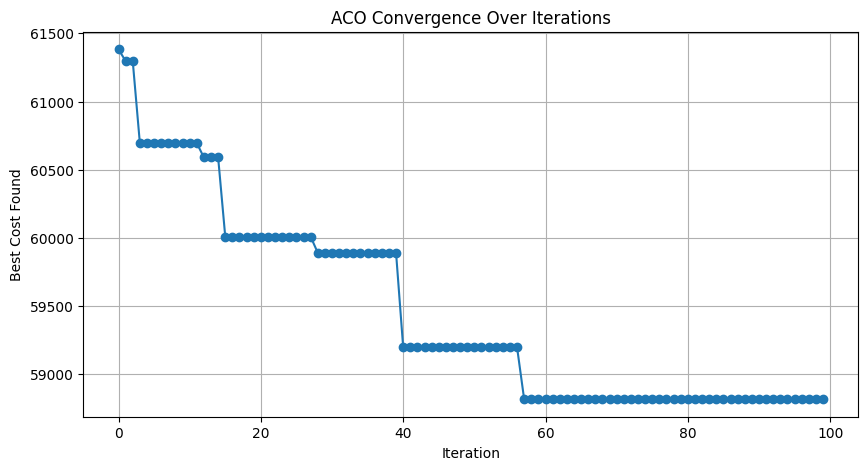

In [5]:
plt.figure(figsize=(10, 5))
plt.plot(best_costs_over_time, marker='o')
plt.xlabel("Iteration")
plt.ylabel("Best Cost Found")
plt.title("ACO Convergence Over Iterations")
plt.grid(True)
plt.show()